# Implémentation TAGI pour regression

In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
import struct
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

# fixe seed
# np.random.seed(0)

# Génération des données avec bruit Gaussien :

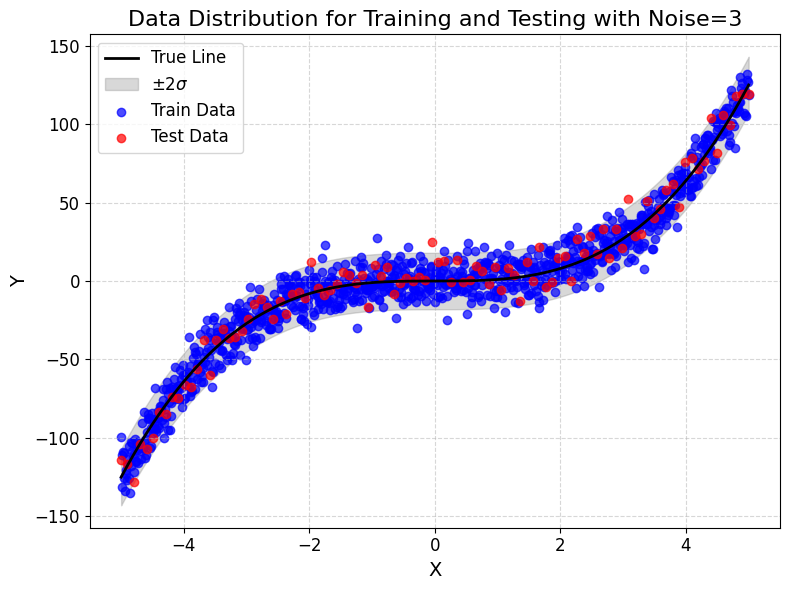

In [5]:
def get_data(n_samples : int = 1000, noise : float = 3, name = 'linear', test=False):
    
    if test:
        if name == 'linear':
            x = np.linspace(-5, 5, n_samples)
            y = x**3 + np.random.randn(len(x))*noise
            X_test = (x, y)
            y = x**3
            X_true = (x, y)
            return X_test, X_true
        
    if name == 'linear':
        x = np.linspace(-5, 5, n_samples)
        y = x**3 + np.random.randn(len(x))*noise
        return x, y

noise = 9
x, y = get_data(n_samples=1000, noise=0)
x_train, y_train = get_data(n_samples=1000, noise=noise)
x_val, y_val = get_data(n_samples=100, noise=noise)
test_data, true_data = get_data(n_samples=100, noise=noise, test=True)
x_test, y_test = test_data
x_true_data, y_true_data = true_data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, label='True Line', color='black', linewidth=2)
ax.fill_between(x, y - 2*noise, y + 2*noise, color='gray', alpha=0.3, label=r'$\pm 2\sigma$')
ax.scatter(x_train, y_train, label='Train Data', color='blue', alpha=0.7, marker='o')
ax.scatter(x_test, y_test, label='Test Data', color='red', alpha=0.7, marker='o')
ax.set_title('Data Distribution for Training and Testing with Noise=3', fontsize=16)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Normalisation des données pour la stabilité du modèle :

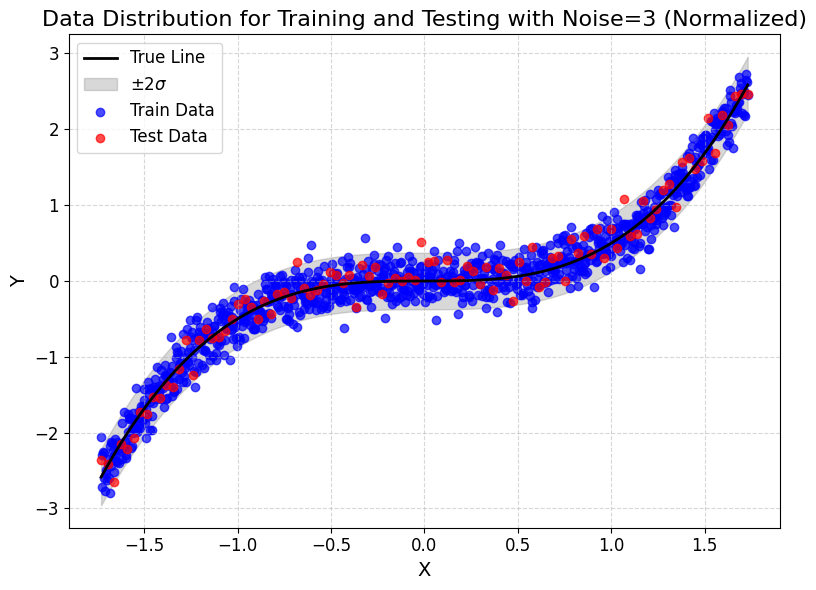

In [6]:
x_train_norm = (x_train - np.mean(x_train)) / np.std(x_train)
y_train_norm = (y_train - np.mean(y_train)) / np.std(y_train)
x_test_norm = (x_test - np.mean(x_train)) / np.std(x_train)
y_test_norm = (y_test - np.mean(y_train)) / np.std(y_train)
x_val_norm = (x_val - np.mean(x_train)) / np.std(x_train)
y_val_norm = (y_val - np.mean(y_train)) / np.std(y_train)
x_norm = (x - np.mean(x_train)) / np.std(x_train)
y_norm = (y - np.mean(y_train)) / np.std(y_train)

standardized_noise = noise / np.std(y_train)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x_norm, y_norm, label='True Line', color='black', linewidth=2)
ax.fill_between(x_norm, y_norm - 2*standardized_noise, y_norm + 2*standardized_noise, color='gray', alpha=0.3, label=r'$\pm 2\sigma$')
ax.scatter(x_train_norm, y_train_norm, label='Train Data', color='blue', alpha=0.7, marker='o')
ax.scatter(x_test_norm, y_test_norm, label='Test Data', color='red', alpha=0.7, marker='o')
ax.set_title('Data Distribution for Training and Testing with Noise=3 (Normalized)', fontsize=16)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='upper left', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# TAGI - Implémentation

## Définition des fonctions :

### Initialisation des paramètres 

In [7]:
def initialize_params(layer_dims, seed = None):
    '''
    Initializes the weights of the neural network.
    
    Inputs :
    layer_dims : list of integers, where the ith element is the number of neurons in the ith layer.
    seed : int, random seed for reproducibility.
    
    Outputs :
    parameters : dictionary containing the weights of the neural network.
    '''
    
    if not all(isinstance(dim, int) for dim in layer_dims):
        raise ValueError("All elements in layer_dims must be integers.")
    
    if seed is not None:
        np.random.seed(seed)
    
    parameters = {}
    L = len(layer_dims) - 1
    
    for l in range(0, L):
        
        mu_w = np.random.normal(0, (np.sqrt(1/layer_dims[l])), (layer_dims[l+1], layer_dims[l]))
        var_w = np.ones((layer_dims[l+1], layer_dims[l]))* 1 / (layer_dims[l])
        
        mu_b = np.random.normal(0, (np.sqrt(1/layer_dims[l])), (layer_dims[l+1], 1))
        var_b = np.ones((layer_dims[l+1], 1)) * (1 / (layer_dims[l]))
        
        mu_theta = np.concatenate((mu_w, mu_b), axis=1)
        var_theta = np.concatenate((var_w, var_b), axis=1)
        parameters[f'theta_{l}'] = (mu_theta, var_theta)
    return parameters

### Feedforward (Generalized)

In [8]:
def linear_forward(A_prev, theta_l, l):
    """
    Implements the linear part of a layer's forward propagation for a batch.
    Inputs:
    A_prev : tuple (mu_a_prev, var_a_prev), activations from previous layer (l-1).
             mu_a_prev shape: (n_neurons_prev, batch_size)
             var_a_prev shape: (n_neurons_prev, batch_size)
             For l=0, A_prev = (X_batch, 0), X_batch shape (n_features, batch_size).
    theta_l: tuple (mu_theta, var_theta), parameters for current layer l.
             mu_theta shape: (n_neurons, n_neurons_prev + 1)
             var_theta shape: (n_neurons, n_neurons_prev + 1)
    l      : int, current layer index.
    Outputs:
    Z_l    : tuple (mu_z, var_z, cov_z_theta), linear output of the layer.
             mu_z shape: (n_neurons, batch_size)
             var_z shape: (n_neurons, batch_size)
             cov_z_theta shape: (n_neurons, n_neurons_prev + 1, batch_size) - Covariance for each sample
    """
    mu_a_prev, var_a_prev = A_prev[0], A_prev[1] # (n_prev, B), (n_prev, B)
    mu_theta, var_theta = theta_l # (n_curr, n_prev+1), (n_curr, n_prev+1)
    mu_w, mu_b = mu_theta[:, :-1], mu_theta[:, -1].reshape(-1, 1) # (n_curr, n_prev), (n_curr, 1)
    var_w, var_b = var_theta[:, :-1], var_theta[:, -1].reshape(-1, 1) # (n_curr, n_prev), (n_curr, 1)
    
    mu_z = mu_w @ mu_a_prev + mu_b # (n_curr, n_prev) @ (n_prev, B) + (n_curr, 1) -> (n_curr, B)
    var_z = var_w @ var_a_prev + var_w @ (mu_a_prev**2) + (mu_w**2) @ var_a_prev + var_b

    # Need to compute this per sample in the batch
    batch_size = mu_a_prev.shape[1]
    cov_z_w = np.einsum('ji,kj->kji', mu_a_prev, var_w) 
    cov_z_b = np.repeat(var_b[:, :, np.newaxis], batch_size, axis=2)
    cov_z_theta = np.concatenate((cov_z_w, cov_z_b), axis=1)
    return (mu_z, var_z, cov_z_theta)

In [9]:
def activation_forward(Z_l, activation_type='relu'):
    """
    Implements the activation function forward pass for a batch.
    Inputs:
    Z_l : tuple (mu_z, var_z, cov_z_theta), linear output of the layer.
          mu_z shape: (n_neurons, batch_size)
          var_z shape: (n_neurons, batch_size)
    activation_type: string, "relu" or "linear".
    Outputs:
    A_l : tuple (mu_a, var_a, T), activated output. T is the Jacobian dA/dZ.
          mu_a shape: (n_neurons, batch_size)
          var_a shape: (n_neurons, batch_size)
          T shape: (n_neurons, batch_size)
    """
    mu_z, var_z, _ = Z_l # (n, B), (n, B)
    if activation_type == 'relu':
        # Heaviside step function T = 1 if mu_z > 0 else 0
        T = np.where(mu_z > 0, 1.0, 0.0) # (n, B)
        mu_a = mu_z * T # (n, B)
        # Approximation: Var(a) approx Var(z) * T^2 (since T is 0 or 1, T^2=T)
        var_a = var_z * T # (n, B)
        return (mu_a, var_a, T)
    elif activation_type == 'linear':
        T = np.ones_like(mu_z)  # Linear activation, T = 1 (n, B)
        # For linear activation, a = z
        return (mu_z, var_z, T)
    else:
        raise ValueError("Unsupported activation type")

In [10]:
def model_forward(X_batch, parameters, layer_dims):
    """
    Implements the full forward pass for the network for a batch.
    Inputs:
    X_batch    : numpy array, input data batch (shape: n_features, batch_size).
    parameters : dict, contains 'theta_l' for each layer l.
    layer_dims : list, dimensions of each layer [n_features, n_h1, ..., n_output].
    Outputs:
    Z_out      : tuple (mu_z, var_z, cov_z_theta), output of the final linear layer.
                 Shapes: (n_output, B), (n_output, B), (n_output, n_prev+1, B)
    caches     : list of dicts, storing intermediate values for backward pass.
                 Each dict contains {'Z': Z_l, 'A_prev': A_prev, 'theta': theta_l, 'A': A_l}
    """
    caches = []
    L = len(layer_dims) - 1 # Number of layers with parameters (0 to L-1)

    # Initial activation is the input batch X_batch
    # mu_a = X_batch, var_a = 0 (assuming input data is deterministic)
    A_prev = (X_batch, np.zeros_like(X_batch)) # (n_features, B), (n_features, B)

    # Iterate through hidden layers (l=0 to L-2)
    for l in range(L - 1):
        theta_l = parameters[f'theta_{l}']
        Z_l = linear_forward(A_prev, theta_l, l)
        A_l = activation_forward(Z_l, activation_type='relu')
        caches.append({'Z': Z_l, 'A_prev': A_prev, 'theta': theta_l, 'A': A_l})
        A_prev = A_l # Output of this layer is input to the next (mu_a, var_a, T)

    # Output layer (l = L-1) - Linear activation
    theta_out = parameters[f'theta_{L-1}']
    Z_out = linear_forward(A_prev, theta_out, L-1)
    # Use linear activation for the final output in regression
    A_out = activation_forward(Z_out, activation_type='linear')
    caches.append({'Z': Z_out, 'A_prev': A_prev, 'theta': theta_out, 'A': A_out})
    return Z_out, caches

### Modèle d'observation

In [11]:
def obs_model(Z_out, var_v):
    """
    Observation model for a batch.
    Inputs:
    Z_out: tuple (mu_z, var_z, _), output of the final linear layer for the batch.
           mu_z shape: (n_output, batch_size)
           var_z shape: (n_output, batch_size)
    var_v: float, observation noise variance (assumed constant for all samples).
    Outputs:
    Y    : tuple (mu_y, var_y), predicted output distribution for the batch.
           mu_y shape: (n_output, batch_size)
           var_y shape: (n_output, batch_size)
    """
    mu_z, var_z, _ = Z_out # (n_out, B), (n_out, B)
    mu_y = mu_z # (n_out, B)
    var_y = var_z + var_v # (n_out, B)
    
    return (mu_y, var_y)

In [12]:
def log_likelihood(Y, y_batch):
    """
    Calculates the total log-likelihood for a batch.
    Inputs:
    Y       : tuple (mu_y, var_y), predicted output distribution for the batch.
              mu_y shape: (n_output, batch_size)
              var_y shape: (n_output, batch_size)
    y_batch : numpy array, true labels for the batch.
              shape: (n_output, batch_size)
    Outputs:
    total_log_ll: float, sum of log-likelihoods over the batch.
    """
    mu_y, var_y = Y # (n_out, B), (n_out, B)
    # Ensure shapes match
    if mu_y.shape != y_batch.shape:
         raise ValueError(f"Shape mismatch: mu_y {mu_y.shape}, y_batch {y_batch.shape}")
         
    # Add small epsilon for numerical stability
    epsilon = 1e-8
    var_y_stable = var_y + epsilon
    
    # Calculate log-likelihood for each sample in the batch
    log_ll_samples = -0.5 * np.log(2 * np.pi) - 0.5 * np.log(var_y_stable) - 0.5 * (y_batch - mu_y)**2 / var_y_stable
    # Sum over the batch and output dimensions (if n_output > 1)
    total_log_ll = np.sum(log_ll_samples)
    
    return total_log_ll

In [13]:
def update_output(Y, Z_out, y_batch):
    """
    Updates the output layer's state (Z_out) based on the batch observation y_batch.
    Inputs:
    Y       : tuple (mu_y, var_y), predicted output distribution for the batch.
              Shapes: (n_output, B)
    Z_out   : tuple (mu_z, var_z, cov_z_theta), original linear output for the batch.
              Shapes: (n_output, B), (n_output, B), (n_output, n_prev+1, B)
    y_batch : numpy array, true labels for the batch.
              shape: (n_output, B)
    Outputs:
    Z_out_y : tuple (mu_z_y, var_z_y), updated linear output state for the batch.
              Shapes: (n_output, B), (n_output, B)
    """
    mu_y, var_y = Y # (n_out, B), (n_out, B)
    mu_z, var_z, _ = Z_out # (n_out, B), (n_out, B)
    
    # Ensure shapes match
    if mu_y.shape != y_batch.shape or mu_z.shape != y_batch.shape:
         raise ValueError("Shape mismatch during output update")

    # Add small epsilon for numerical stability
    epsilon = 1e-8
    var_y_stable = var_y + epsilon

    # Kalman gain like term K = Var(z) / Var(y)
    K = var_z / var_y_stable # (n_out, B)
    
    # Update mean: mu_z_y = mu_z + K * (y - mu_y)
    mu_z_y = mu_z + K * (y_batch - mu_y) # (n_out, B)
    
    # Update variance: var_z_y = var_z - K * Var(z) = Var(z) * (1 - K)
    var_z_y = var_z * (1 - K) # (n_out, B)
    
    # Ensure variance remains non-negative
    var_z_y = np.maximum(epsilon, var_z_y)
    return (mu_z_y, var_z_y)

### Inférence (Generalized Backward Pass)

In [14]:
def update_parameters(Z_l, Z_l_y, theta_l):
    """
    Updates the parameters (theta_l) of layer l based on the updated batch state Z_l_y.
    Averages the update across the batch dimension.
    Inputs:
    Z_l     : tuple (mu_z, var_z, cov_z_theta), original linear output for the batch.
              Shapes: (n_curr, B), (n_curr, B), (n_curr, n_prev+1, B)
    Z_l_y   : tuple (mu_z_y, var_z_y), updated linear output state for the batch.
              Shapes: (n_curr, B), (n_curr, B)
    theta_l : tuple (mu_theta, var_theta), original parameters of layer l.
              Shapes: (n_curr, n_prev+1), (n_curr, n_prev+1)
    Outputs:
    theta_l_y: tuple (mu_theta_y, var_theta_y), updated parameters (averaged over batch).
               Shapes: (n_curr, n_prev+1), (n_curr, n_prev+1)
    """
    mu_z, var_z, cov_z_theta = Z_l # (n_curr, B), (n_curr, B), (n_curr, n_prev+1, B)
    mu_z_y, var_z_y = Z_l_y       # (n_curr, B), (n_curr, B)
    mu_theta, var_theta = theta_l # (n_curr, n_prev+1), (n_curr, n_prev+1)
    epsilon = 1e-8 
    var_z_stable = var_z + epsilon # (n_curr, B)
    J_theta = cov_z_theta / var_z_stable[:, np.newaxis, :] 

    # Calculate state changes for each sample
    delta_mu_z = mu_z_y - mu_z   # (n_curr, B)
    delta_var_z = var_z_y - var_z # (n_curr, B)

    # Use einsum for clarity and potential efficiency
    delta_mu_theta = np.einsum('kib,kb->kib', J_theta, delta_mu_z)
    delta_var_theta = np.einsum('kib,kb->kib', J_theta**2, delta_var_z)
    # Average updates over the batch dimension (axis=2)
    avg_delta_mu_theta = np.mean(delta_mu_theta, axis=2) # (n_curr, n_prev+1)
    avg_delta_var_theta = np.mean(delta_var_theta, axis=2) # (n_curr, n_prev+1)

    # Update parameters using averaged deltas
    mu_theta_y = mu_theta + avg_delta_mu_theta
    # Ensure variance doesn't become negative
    var_theta_y = np.maximum(epsilon, var_theta + avg_delta_var_theta) 
    return (mu_theta_y, var_theta_y)

In [15]:
def update_hidden_state(Z_l, Z_l_plus_1, Z_l_plus_1_y, A_l, theta_l_plus_1):
    """
    Updates the hidden state Z_l based on the updated batch state of the next layer Z_{l+1}_y.
    Inputs:
    Z_l           : tuple (mu_z, var_z, _), original linear output of layer l for the batch.
                    Shapes: (n_l, B), (n_l, B)
    Z_l_plus_1    : tuple (mu_z_next, var_z_next, _), original linear output of layer l+1 for the batch.
                    Shapes: (n_l+1, B), (n_l+1, B)
    Z_l_plus_1_y  : tuple (mu_z_next_y, var_z_next_y), updated linear output of layer l+1 for the batch.
                    Shapes: (n_l+1, B), (n_l+1, B)
    A_l           : tuple (mu_a, var_a, T), activation output of layer l for the batch. T is dA/dZ.
                    Shapes: (n_l, B), (n_l, B), (n_l, B)
    theta_l_plus_1: tuple (mu_theta_next, var_theta_next), original parameters of layer l+1.
                    Shapes: (n_l+1, n_l+1), (n_l+1, n_l+1)
    Outputs:
    Z_l_y         : tuple (mu_z_y, var_z_y), updated linear output state of layer l for the batch.
                    Shapes: (n_l, B), (n_l, B)
    """
    mu_z, var_z, _ = Z_l                 # (n_l, B), (n_l, B)
    mu_z_next, var_z_next, _ = Z_l_plus_1 # (n_l+1, B), (n_l+1, B)
    mu_z_next_y, var_z_next_y = Z_l_plus_1_y # (n_l+1, B), (n_l+1, B)
    _, _, T = A_l                        # (n_l, B) - Jacobian dA/dZ for layer l
    mu_theta_next, _ = theta_l_plus_1    # (n_l+1, n_l+1)
    mu_w_next = mu_theta_next[:, :-1]    # (n_l+1, n_l) - Weights connecting l to l+1
    epsilon = 1e-8
    var_z_next_stable = var_z_next + epsilon # (n_l+1, B)
    cov_z_next_z = np.einsum('kj,jb,jb->kjb', mu_w_next, var_z, T)# Shape: (n_l+1, n_l, B)
    J_z = cov_z_next_z / var_z_next_stable[:, np.newaxis, :]# Shape: (n_l+1, n_l, B) / (n_l+1, 1, B) -> (n_l+1, n_l, B)

    # Calculate state changes in the next layer
    delta_mu_z_next = mu_z_next_y - mu_z_next # (n_l+1, B)
    delta_var_z_next = var_z_next_y - var_z_next # (n_l+1, B)
    delta_mu_z = np.einsum('kji,ki->ji', J_z, delta_mu_z_next)   # (n_l, B)
    delta_var_z = np.einsum('kji,ki->ji', J_z**2, delta_var_z_next) # (n_l, B)

    # Update state Z_l
    mu_z_y = mu_z + delta_mu_z
    var_z_y = var_z + delta_var_z
    
    return (mu_z_y, np.maximum(epsilon, var_z_y))

In [16]:
def model_backward(Y, Z_out, y_batch, caches, parameters, layer_dims):
    """
    Implements the full backward pass (inference/update) for the network for a batch.
    Inputs:
    Y          : tuple (mu_y, var_y), batch output of observation model. Shapes (n_out, B)
    Z_out      : tuple (mu_z, var_z, cov), batch output of the final linear layer.
                 Shapes: (n_out, B), (n_out, B), (n_out, n_prev+1, B)
    y_batch    : numpy array, true labels for the batch. Shape (n_out, B)
    caches     : list of dicts from forward pass (containing batch results).
    parameters : dict, current parameters 'theta_l'.
    layer_dims : list, dimensions of each layer.
    Outputs:
    updated_params: dict, containing batch-updated 'theta_l' for each layer.
    # Z_updates     : dict, containing updated 'Z_l_y' for each layer state (optional).
    """
    updated_params = {}
    L = len(layer_dims) - 1 # Number of layers with parameters

    # 1. Update output state Z_out based on batch observation y_batch
    Z_out_y = update_output(Y, Z_out, y_batch) # Z_out_y shapes: (n_out, B)
    Z_next_y = Z_out_y # This is the starting point for backpropagation (n_out, B)

    # 2. Update parameters of the output layer (l = L-1)
    cache_out = caches[L-1] # Cache for the output layer (contains batch Z, A_prev, theta, A)
    # theta_l = cache_out['theta'] -> (mu_theta, var_theta) shapes (n_out, n_L-1+1)
    theta_out_y = update_parameters(cache_out['Z'], Z_out_y, cache_out['theta'])
    updated_params[f'theta_{L-1}'] = theta_out_y

    # 3. Iterate backwards through hidden layers (l = L-2 down to 0)
    for l in reversed(range(L - 1)):
        # Get states and parameters for current (l) and next (l+1) layers from caches
        cache_l = caches[l]
        cache_l_plus_1 = caches[l+1]
        
        Z_l = cache_l['Z']             # (mu_z, var_z, cov), shapes (n_l, B), (n_l, B), (n_l, n_l-1+1, B)
        A_l = cache_l['A']             # (mu_a, var_a, T), shapes (n_l, B), (n_l, B), (n_l, B)
        theta_l = cache_l['theta']     # (mu_theta, var_theta), shapes (n_l, n_l-1+1)
        
        Z_l_plus_1 = cache_l_plus_1['Z'] # (mu_z_next, var_z_next, _), shapes (n_l+1, B), (n_l+1, B)
        
        # Use the *original* parameters of the next layer (l+1) for Jacobian calculation
        # These parameters were used in the forward pass to generate Z_l_plus_1
        theta_l_plus_1 = parameters[f'theta_{l+1}'] # Shapes (n_l+1, n_l+1)

        # Update hidden state Z_l using Z_{l+1}_y (which is Z_next_y)
        # Z_next_y has shape (n_l+1, B)
        Z_l_y = update_hidden_state(Z_l, Z_l_plus_1, Z_next_y, A_l, theta_l_plus_1) # Z_l_y shapes (n_l, B)

        # Update parameters theta_l using the updated state Z_l_y
        theta_l_y = update_parameters(Z_l, Z_l_y, theta_l)
        updated_params[f'theta_{l}'] = theta_l_y

        # Pass the updated state Z_l_y backward for the next iteration
        Z_next_y = Z_l_y # Shape (n_l, B)
        
    return updated_params#, Z_updates

### Entrainement

Définir l'architecture du réseau de neurones :

Exemple: Input -> 100 neurones -> 100 neurones -> Output

In [17]:
batch_size = 10 # Define batch size
layer_dims = [1, 100, 100, 1] # Input feature is 1D
parameters = initialize_params(layer_dims, seed=42)
best_params = parameters.copy()

Définir les hyperparamètres :

In [18]:
n_epochs = 100 # Adjust as needed
log_ll_train = []
log_ll_val = []
log_ref = -np.inf # Initialize with negative infinity

Redimensionner les données d'entrée pour correspondre à la taille du lot

In [19]:
x_train_batch = x_train_norm.reshape(1, -1)
y_train_batch = y_train_norm.reshape(1, -1)
x_val_batch = x_val_norm.reshape(1, -1)
y_val_batch = y_val_norm.reshape(1, -1)
x_test_batch = x_test_norm.reshape(1, -1)
y_test_batch = y_test_norm.reshape(1, -1)
n_samples_train = x_train_batch.shape[1]

Entraîner le modèle :

In [20]:
for epoch in tqdm(range(n_epochs), desc="Training Epochs"):
    epoch_log_likelihood_train = 0
    
    # Shuffle training data each epoch
    indices = np.random.permutation(n_samples_train)
    x_train_shuffled = x_train_batch[:, indices]
    y_train_shuffled = y_train_batch[:, indices]
    
    # Iterate over mini-batches
    for i in range(0, n_samples_train, batch_size):
        # Get mini-batch
        end_idx = min(i + batch_size, n_samples_train)
        x_batch_i = x_train_shuffled[:, i:end_idx]
        y_batch_i = y_train_shuffled[:, i:end_idx]
        
        # Forward pass for the batch
        # Ensure x_batch_i has shape (1, current_batch_size)
        if x_batch_i.ndim == 1:
             x_batch_i = x_batch_i.reshape(1, -1) # Reshape if it became 1D
        Z_out, caches = model_forward(x_batch_i, parameters, layer_dims)

        # Observation model for the batch
        Y = obs_model(Z_out, standardized_noise**2) # Y = (mu_y, var_y) shapes (n_out, B)

        # Calculate log likelihood for the batch
        batch_log_likelihood = log_likelihood(Y, y_batch_i) # y_batch_i shape (n_out, B)
        
        # Backward pass (Inference/Update) for the batch
        # Now uses the batch-aware backward functions
        updated_params = model_backward(Y, Z_out, y_batch_i, caches, parameters, layer_dims)
        
        # Update parameters using the batch updates
        parameters.update(updated_params) 
        
        # Accumulate log likelihood for the epoch
        epoch_log_likelihood_train += batch_log_likelihood # Summing log-likelihoods is correct

    # Average log likelihood for the epoch
    log_ll_train.append(epoch_log_likelihood_train / n_samples_train)

    # Evaluate the model on the validation data (using batches)
    total_log_likelihood_val = 0
    n_samples_val = x_val_batch.shape[1]
    for i in range(0, n_samples_val, batch_size):
         end_idx = min(i + batch_size, n_samples_val)
         x_val_batch_i = x_val_batch[:, i:end_idx]
         y_val_batch_i = y_val_batch[:, i:end_idx]
         if x_val_batch_i.ndim == 1:
             x_val_batch_i = x_val_batch_i.reshape(1, -1)
         if y_val_batch_i.ndim == 1:
             y_val_batch_i = y_val_batch_i.reshape(1, -1)
         # Forward pass for validation batch
         Z_out_val, _ = model_forward(x_val_batch_i, parameters, layer_dims)
         Y_val = obs_model(Z_out_val, standardized_noise**2)
         
         # Calculate batch log likelihood
         batch_log_ll_val = log_likelihood(Y_val, y_val_batch_i)
         total_log_likelihood_val += batch_log_ll_val

    # Average validation log likelihood
    avg_log_ll_val = total_log_likelihood_val / n_samples_val
    log_ll_val.append(avg_log_ll_val)
    
    # Check for best parameters based on validation log likelihood
    if avg_log_ll_val > log_ref:
        log_ref = avg_log_ll_val
        best_params = parameters.copy() # Store deep copy
        # print(f"Epoch {epoch}: New best validation log-likelihood: {log_ref:.4f}")

best_epoch_idx = np.argmax(log_ll_val)
parameters = best_params
print(f'Best validation log-likelihood ({log_ll_val[best_epoch_idx]:.4f}) at epoch: {best_epoch_idx}')

Training Epochs: 100%|██████████| 100/100 [00:13<00:00,  7.37it/s]

Best validation log-likelihood (0.0773) at epoch: 98


Visualiser les résultats :

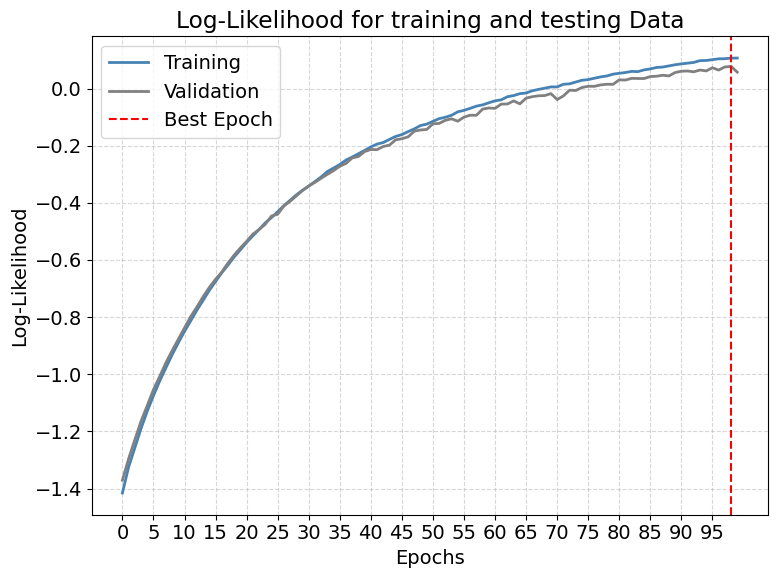

In [21]:
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})  # Update font size
plt.plot(log_ll_train, label='Training', color='steelblue', linewidth=2)
plt.plot(log_ll_val, label='Validation', color='grey', linewidth=2)
best_epoch = np.argmax(log_ll_val)
plt.axvline(best_epoch, color='red', linestyle='--', label='Best Epoch')
plt.xlabel('Epochs')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood for training and testing Data')
plt.xticks(np.arange(0, n_epochs, 5))  # Set ticks for every 5 epochs
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()  
plt.show()

Données de test :

In [22]:
y_pred_list = []
var_pred_list = []
test_log_likelihood = 0
n_samples_test = x_test_batch.shape[1]
for i in range(0, n_samples_test, batch_size):
    end_idx = min(i + batch_size, n_samples_test)
    x_test_batch_i = x_test_batch[:, i:end_idx]
    y_test_batch_i = y_test_batch[:, i:end_idx] # Ground truth for likelihood calculation
    if x_test_batch_i.ndim == 1:
        x_test_batch_i = x_test_batch_i.reshape(1, -1)

    # Forward pass using the best parameters found during validation
    Z_out_test, _ = model_forward(x_test_batch_i, best_params, layer_dims)
    
    # Forward pass using the best parameters found during validation
    Z_out_test, _ = model_forward(x_test_batch_i, best_params, layer_dims)
    Y_test = obs_model(Z_out_test, standardized_noise**2) # (mu_y, var_y) shapes (n_out, B)

    # Calculate log likelihood for the test batch
    batch_test_log_likelihood = log_likelihood(Y_test, y_test_batch_i)
    test_log_likelihood += batch_test_log_likelihood

    # Store predictions (mean and variance) for the batch
    mu_y_test, var_y_test = Y_test
    y_pred_list.append(mu_y_test) # Append batch means
    var_pred_list.append(var_y_test) # Append batch variances
    
y_pred = np.concatenate(y_pred_list, axis=1).flatten() # Flatten to 1D array matching original output
var_pred = np.concatenate(var_pred_list, axis=1).flatten() # Flatten to 1D array
avg_test_log_ll = test_log_likelihood / n_samples_test
print(f"Average Log-Likelihood on Test Set: {avg_test_log_ll:.4f}")

Average Log-Likelihood on Test Set: 0.0995


Visualiser les résultats dans l'espace non normalisé :

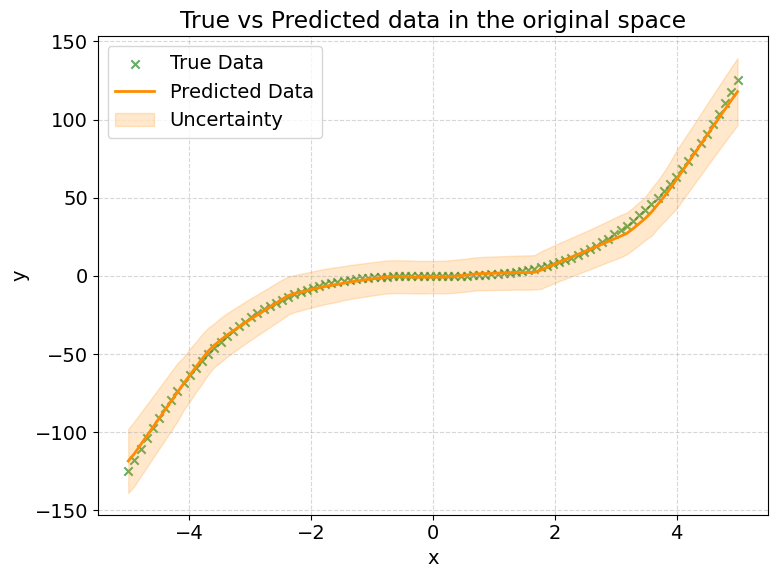

In [23]:
y_pred_orig = np.array(y_pred) * np.std(y_train) + np.mean(y_train)
var_pred_orig = np.array(var_pred) * np.std(y_train)**2
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 14})
plt.scatter(x_true_data, y_true_data, label='True Data', color='forestgreen', alpha=0.7, marker='x')
plt.plot(x_test, y_pred_orig, label='Predicted Data', color='darkorange', linewidth=2)
plt.fill_between(x_test, np.array(y_pred_orig) - np.sqrt(var_pred_orig), np.array(y_pred_orig) + np.sqrt(var_pred_orig), alpha=0.2, label='Uncertainty', color='darkorange')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True vs Predicted data in the original space')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Métrique de performance - dataset de test et true dataset

In [24]:
mse = mean_squared_error(y_test, y_pred_orig)
mae = mean_absolute_error(y_test, y_pred_orig)
r2 = r2_score(y_test, y_pred_orig)
print("Metrics:")
print("{:<20} {:.2f}".format("Mean Squared Error:", mse))
print("{:<20} {:.2f}".format("Mean Absolute Error:", mae))
print("{:<20} {:.2f}".format("R-squared:", r2))
mse = mean_squared_error(y_pred_orig, y_true_data)
mae = mean_absolute_error(y_pred_orig, y_true_data)
r2 = r2_score(y_pred_orig, y_true_data)
print("Metrics:")
print("{:<20} {:.2f}".format("Mean Squared Error:", mse))
print("{:<20} {:.2f}".format("Mean Absolute Error:", mae))
print("{:<20} {:.2f}".format("R-squared:", r2))

Metrics:
Mean Squared Error:  86.77
Mean Absolute Error: 7.22
R-squared:           0.97
Metrics:
Mean Squared Error:  4.57
Mean Absolute Error: 1.46
R-squared:           1.00
